In [1]:
import sys
import os
import time

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [2]:
tend=45
# time_limit=[25, 45]
time_limit=[0, 20]
# time_limit=[10, 30]

In [3]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([tend,])
)

domain_init_kwargs

{'xmin': array([0.]), 'xmax': array([45])}

In [4]:
from PredatorPreySystem.PredatorPreyProblem import PredatorPrey

problem = PredatorPrey
# params = [1.0, 0.1, 0.75, 0.25]
params = [0.5, 0.1, 0.25, 1.25]

problem_init_kwargs = dict(params=params, 
                    u0=5, v0=10, sd=0.1, time_limit=time_limit, 
                    numx=100, lambda_phy=1e2, lambda_data=4*1e3,
                    sparse=False, noise_level=0.05, tend=tend,
                    )

In [5]:
# Nonuniform subdomaining
from fbpinns.decompositions import RectangularDecompositionND
from FBPINNsModel.subdomain_helper import get_subdomain_xsws

decomposition = RectangularDecompositionND
w=1.5
nsub= 10
subdomain_xs, subdomain_ws = get_subdomain_xsws(time_limit, 0, tend, nsub, w, 1.0005)
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    subdomain_ws = subdomain_ws,
    unnorm = (0., 1.),
)
decomposition_init_kwargs

{'subdomain_xs': [array([ 1.11111111,  3.33333333,  5.55555556,  7.77777778, 10.        ,
         12.22222222, 14.44444444, 16.66666667, 18.88888889, 32.5       ])],
 'subdomain_ws': [array([ 3.33333333,  3.33333333,  3.33333333,  3.33333333,  3.33333333,
          3.33333333,  3.33333333,  3.33333333,  3.33333333, 25.0125    ])],
 'unnorm': (0.0, 1.0)}

In [6]:
from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1, 15, 15 , 15,2],# with 2 hidden layers
)

In [7]:
from fbpinns.constants import Constants
rootdir="NonuniformSD/"
run="test"

class ModifiedConstants(Constants):
    @property
    def summary_out_dir(self):
        return f"{rootdir}/summaries/{self.run}/"
    @property
    def model_out_dir(self):
        return f"{rootdir}/models/{self.run}/"

c = ModifiedConstants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# use 200 collocation points for training
    n_test=(200,),# use 500 points for testing
    n_steps=50000,# number of training steps
    clear_output=True,
    sampler='grid',
    save_figures=True,
)

out_dir = c.summary_out_dir
print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([45])}
problem: <class 'PredatorPreySystem.PredatorPreyProblem.PredatorPrey'>
problem_init_kwargs: {'params': [0.5, 0.1, 0.25, 1.25], 'u0': 5, 'v0': 10, 'sd': 0.1, 'time_limit': [0, 20], 'numx': 100, 'lambda_phy': 100.0, 'lambda_data': 4000.0, 'sparse': False, 'noise_level': 0.05, 'tend': 45}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([ 1.11111111,  3.33333333,  5.55555556,  7.77777778, 10.        ,
       12.22222222, 14.44444444, 16.66666667, 18.88888889, 32.5       ])], 'subdomain_ws': [array([ 3.33333333,  3.33333333,  3.33333333,  3.33333333,  3.33333333,
        3.33333333,  3.33333333,  3.33333333,  3.33333333, 25.0125    ])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 15, 15, 15, 2]}
n_steps: 50000
scheduler: <class 'fb

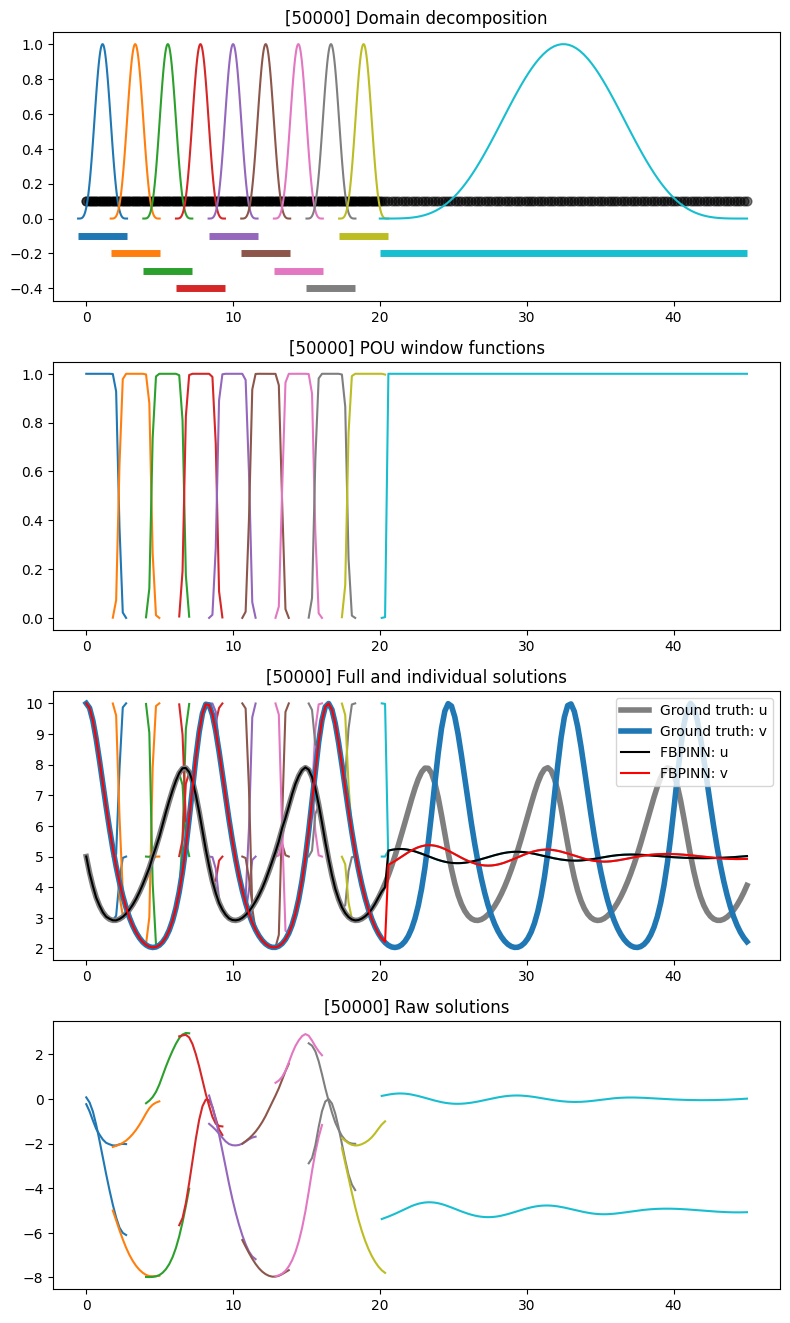

[INFO] 2024-04-06 16:58:38 - [i: 50000/50000] Training complete
85.68207287788391


In [8]:
from fbpinns.trainers import FBPINNTrainer
# step 7:
training_time = time.time()
FBPINNrun = FBPINNTrainer(c)
all_params = FBPINNrun.train()

training_time = time.time() - training_time
print(training_time)

In [9]:
a, b, c, d= [format(round(all_params['trainable']["problem"][key], 2), '.2f') for key in ('a', 'b', 'c', 'd')]
print(a, b, c, d)

a, b, c, d = [all_params['static']["problem"][key] for key in ('a_true', 'b_true', 'c_true', 'd_true')]
print(a, b, c, d)

0.49 0.10 0.25 1.25
0.5 0.1 0.25 1.25


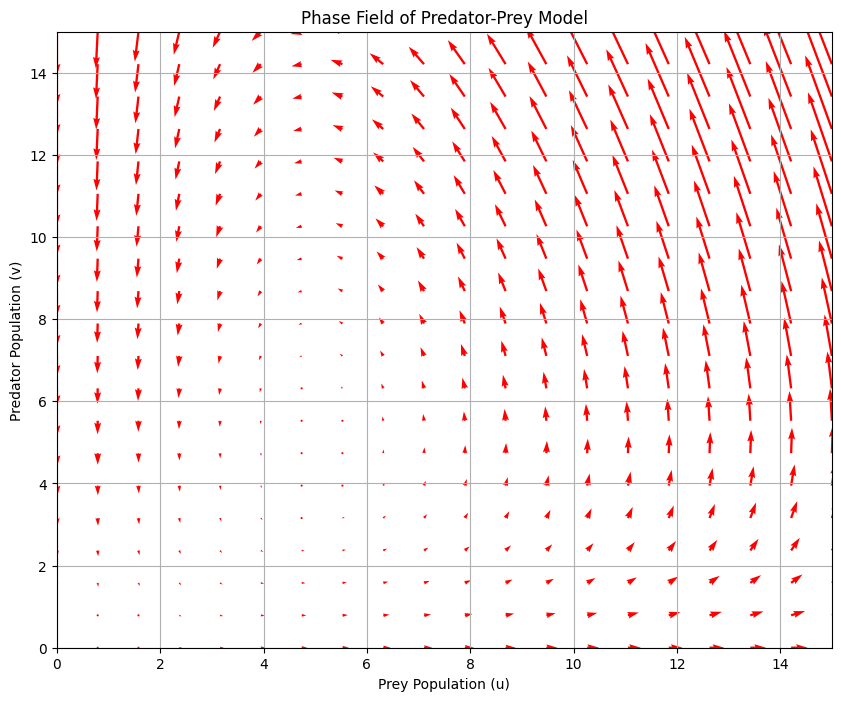

In [10]:
import matplotlib.pyplot as plt
# unstable
# v* = a/b = 10, u* = d/c = 0.33
# let's change the a and b
# v* = a/b = 5, u* = d/c = 5
# a = 0.5, b = 0.1, c = 0.25, d=1.25
a, b, c, d =[0.5, 0.1, 0.25, 1.25]


u_values = np.linspace(0, 15, 20)
v_values = np.linspace(0, 15, 20)
U, V = np.meshgrid(u_values, v_values)

# ode's
du_dt = a*U - b*U*V
dv_dt = c*U*V - d*V

# phase field
plt.figure(figsize=(10, 8))
plt.quiver(U, V, du_dt, dv_dt, color='r')

plt.title('Phase Field of Predator-Prey Model')
plt.xlabel('Prey Population (u)')
plt.ylabel('Predator Population (v)')
plt.xlim([0, max(u_values)])
plt.ylim([0, max(v_values)])
plt.grid(True)
plt.show()


Load model and see the stats

In [11]:
from fbpinns.analysis import load_model
rootdir="NonuniformSD/"
run="test"

c_out, model = load_model(run=run, rootdir=rootdir)

[INFO] 2024-04-06 16:58:38 - Loading model from:
NonuniformSD/models/test/model_00050000.jax


[INFO] 2024-04-06 16:58:39 - x_batch
[INFO] 2024-04-06 16:58:39 - (200, 1), float32, ArrayImpl
[INFO] 2024-04-06 16:58:39 - x_take
[INFO] 2024-04-06 16:58:39 - (241, 1), float32, ArrayImpl


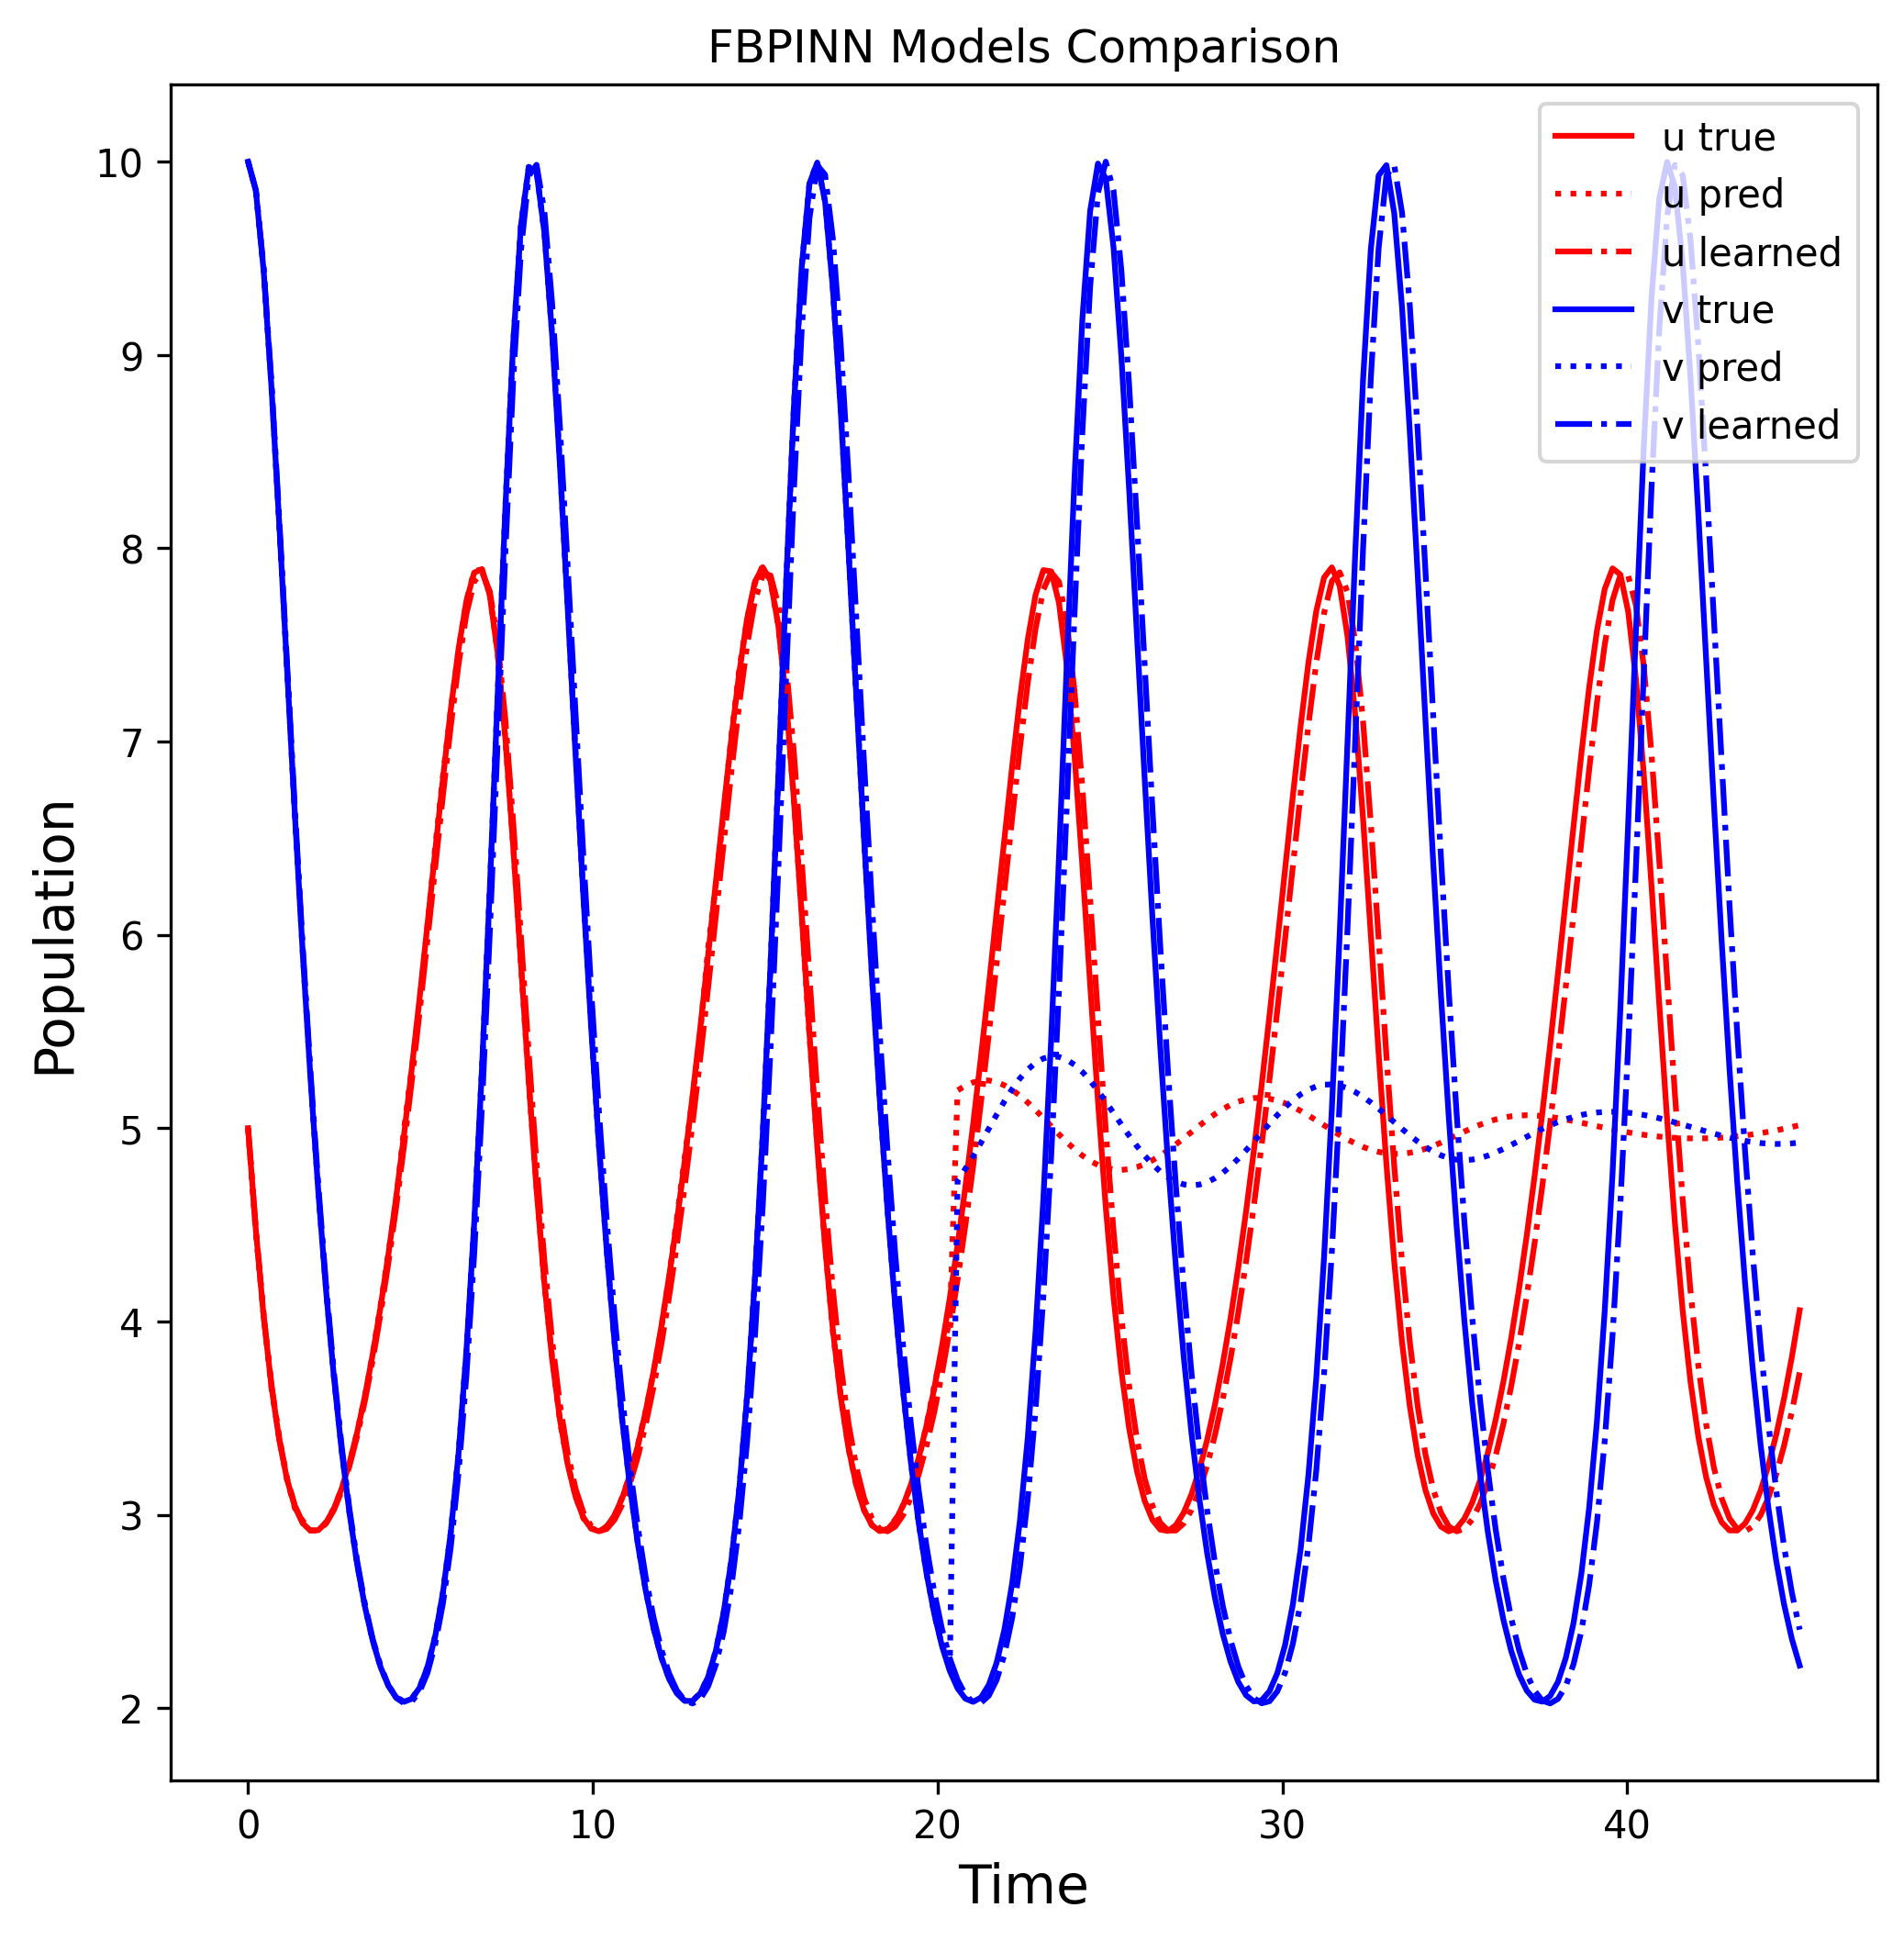

In [12]:
from FBPINNsModel.plot import plot_model_comparison
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
plot_model_comparison(c_out, model, type="FBPINN", ax=ax)

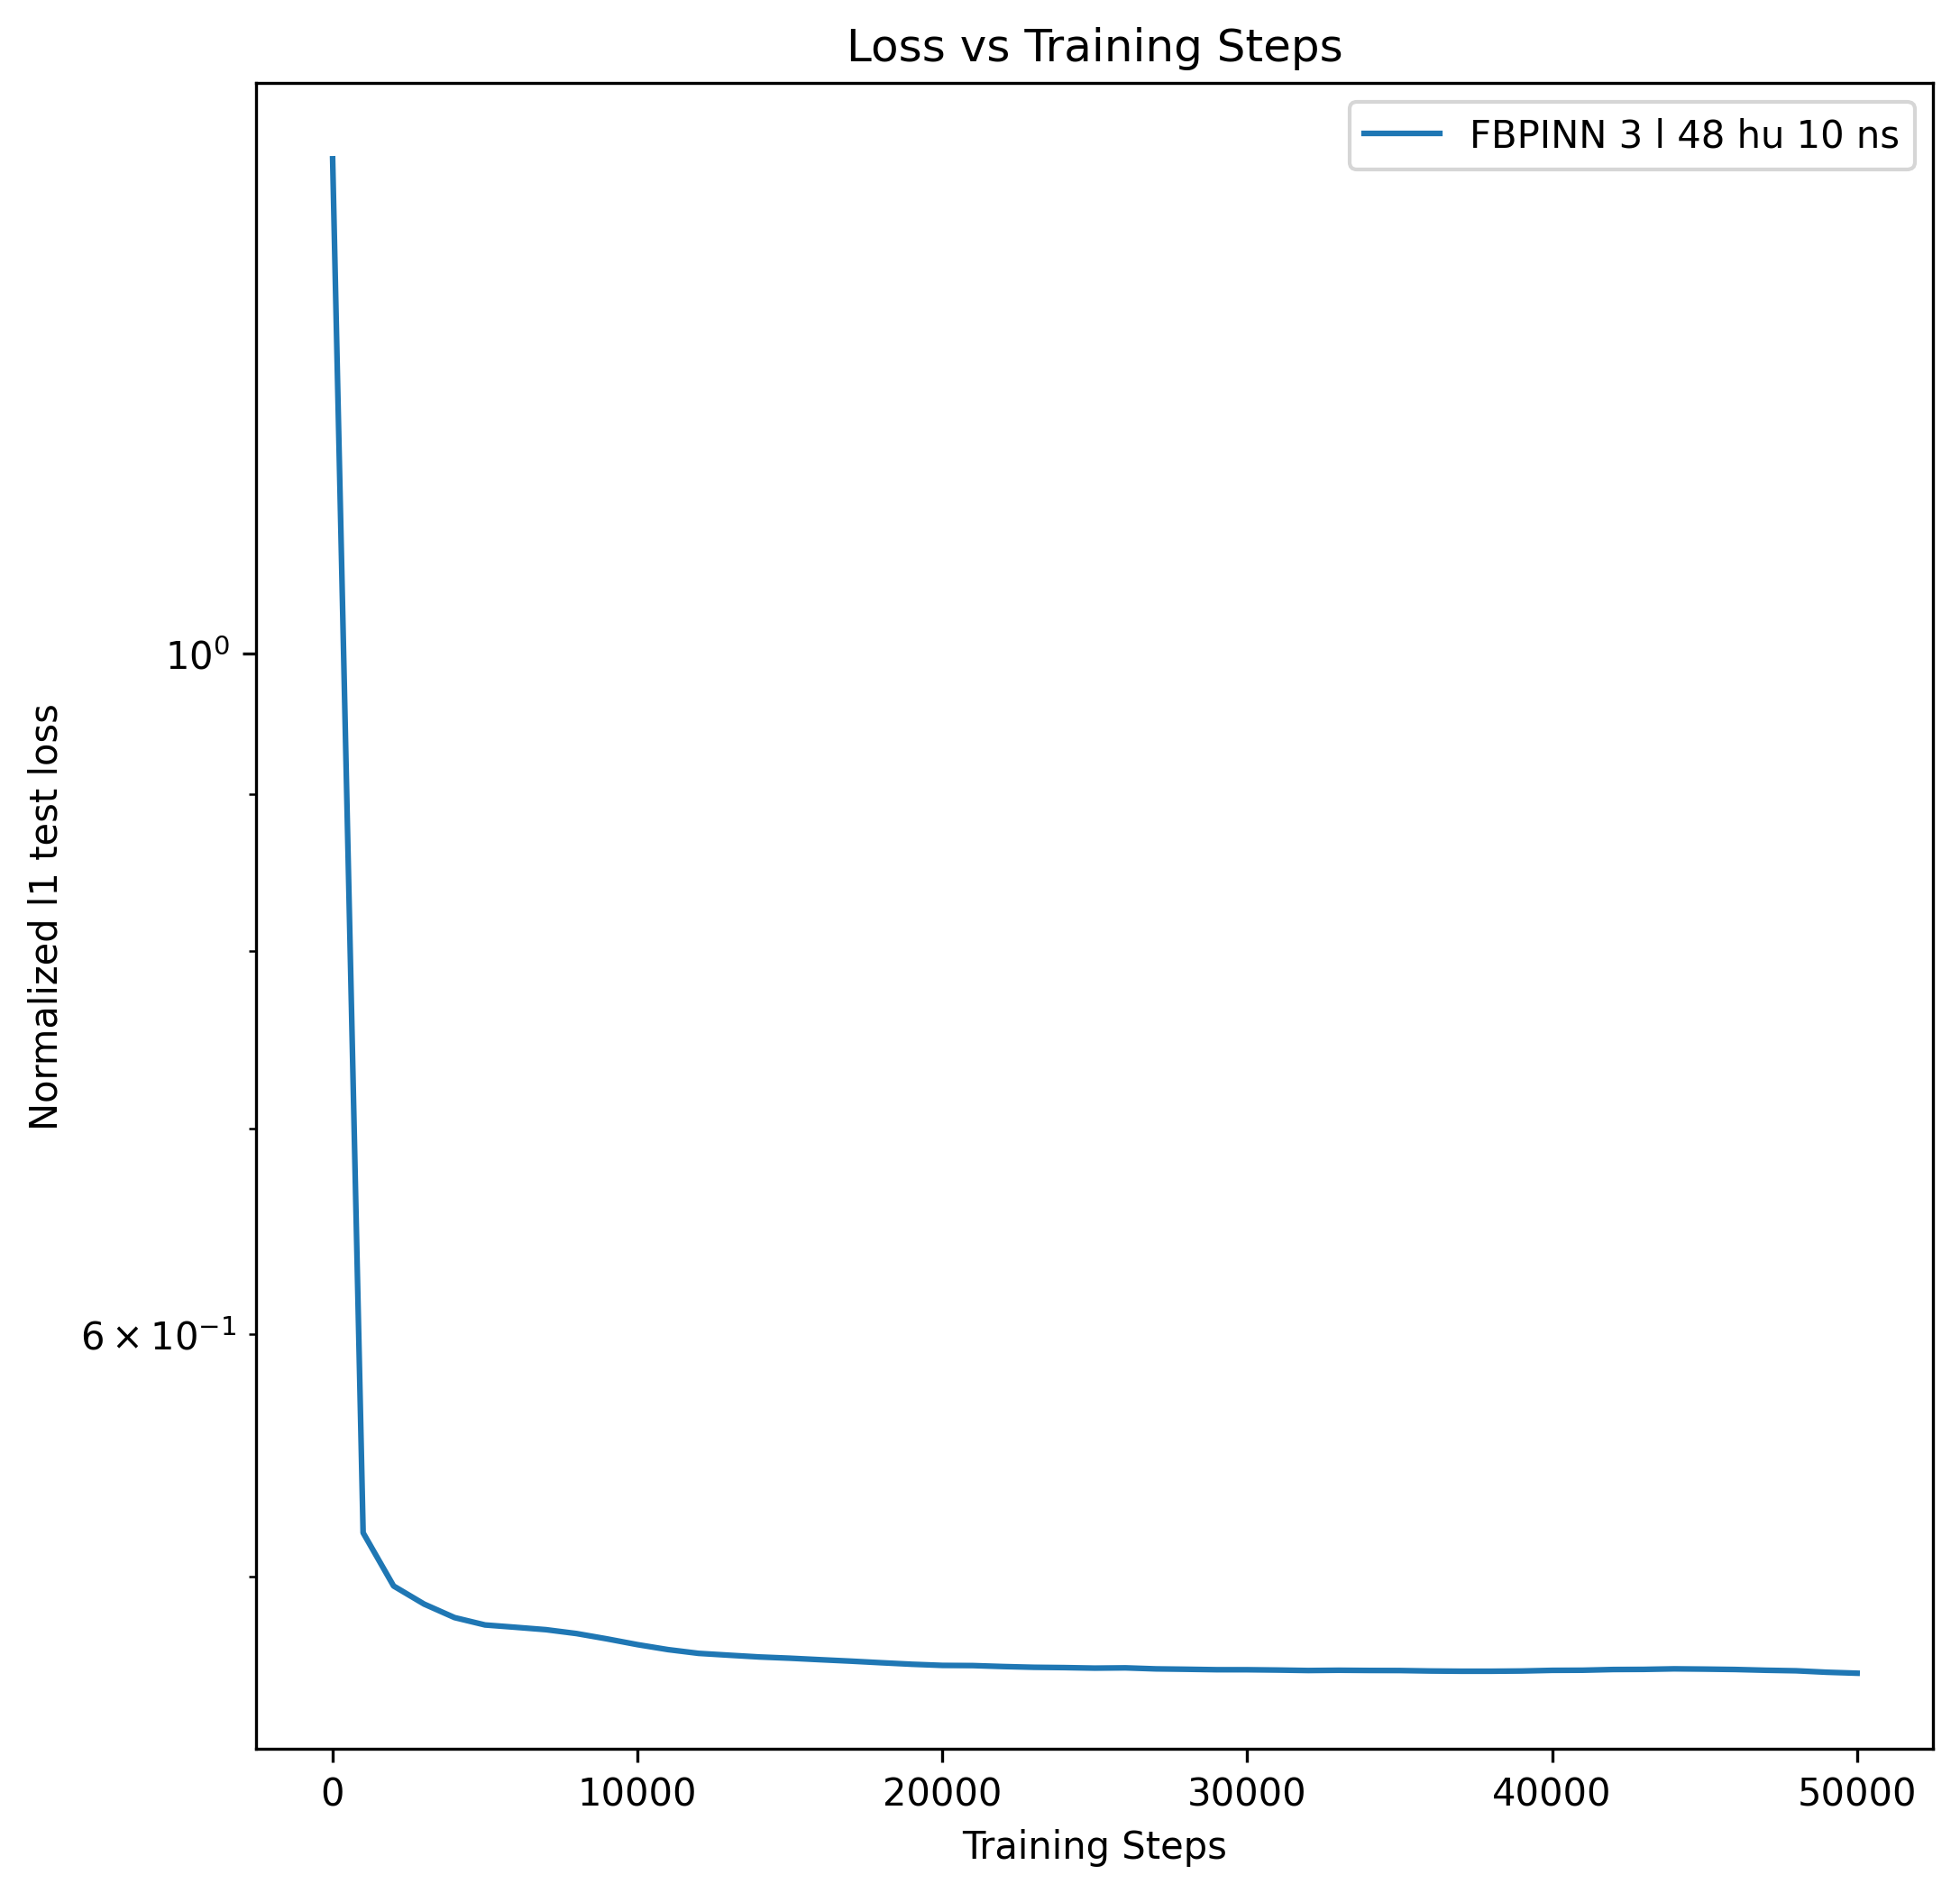

In [13]:
# plots
# 2. N-l1 test loss vs training steps
h = len(network_init_kwargs["layer_sizes"]) - 2  # Number of hidden layers
p = sum(network_init_kwargs["layer_sizes"]) 
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
i,t,l1n = model[-1][:,0], model[-1][:,3], model[-1][:,-1]
ax.plot(i, l1n, label=f"FBPINN {h} l {p} hu {nsub} ns")
ax.set_yscale('log')
ax.set_xlabel('Training Steps')
ax.set_ylabel('Normalized l1 test loss')
ax.set_title('Loss vs Training Steps')
ax.legend()

In [14]:
from FBPINNsModel.plot import get_us, export_mse_mae
# Mse & Mae
u_exact, u_test, u_learned = get_us(c_out, model, type="FBPINN")
file_path = os.path.join(out_dir, "metrices.csv")
export_mse_mae(u_exact, u_test, u_learned, file_path)


[INFO] 2024-04-06 16:58:42 - x_batch
[INFO] 2024-04-06 16:58:42 - (200, 1), float32, ArrayImpl
[INFO] 2024-04-06 16:58:42 - x_take
[INFO] 2024-04-06 16:58:42 - (241, 1), float32, ArrayImpl
